In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k, recall_at_k

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [3]:
#data = pd.read_csv(root+'transaction_data.csv')
data = pd.read_csv('K:/2020/Programming/Data Science/Рекомендательные системы/Урок 3/test/transaction_data.csv')
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
#item_features = pd.read_csv(root+'product.csv')
item_features = pd.read_csv('K:/2020/Programming/Data Science/Рекомендательные системы/Урок 3/test/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
item_features.department.nunique()

44

In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [8]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [9]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)



item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

#print(userid_to_id)
#print(itemid_to_id)

In [11]:
%%time

model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 10.2 s
Wall time: 1.68 s


In [12]:
userid_to_id[2]

1

In [13]:
recs

[(4150, 0.99606687),
 (2371, 0.9955158),
 (3397, 0.9505663),
 (4011, 0.9175228),
 (2297, 0.91094524)]

In [14]:
[id_to_itemid[rec[0]] for rec in recs]

[5569230, 999999, 1082185, 1133018, 995242]

In [15]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)]
    return res

In [16]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: total: 766 ms
Wall time: 184 ms


In [17]:
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

0.1750878955298845

In [18]:
result.head(2)

,user_id,actual,als
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1056509, 885290, 995242, 1100972, 1033142]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[908531, 951590, 883404, 5569230, 822407]"


In [19]:
model.item_factors.shape

(5001, 44)

In [20]:
model.user_factors.shape

(2500, 44)

In [21]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2500, 5001)

In [22]:
fast_recs

array([[-0.00033201,  0.0024285 ,  0.00554678, ...,  0.05010229,
        -0.02215088, -0.05179907],
       [ 0.00703725,  0.0191257 , -0.01510943, ...,  0.0563228 ,
        -0.00380302, -0.03032981],
       [-0.00314857,  0.01492373, -0.02354497, ...,  0.00722463,
         0.03555126,  0.13055563],
       ...,
       [ 0.01063762,  0.02873496, -0.00486183, ...,  0.07390349,
         0.03908448,  0.05952344],
       [ 0.00510918,  0.03046062, -0.00660915, ...,  0.05850191,
         0.21831176,  0.08204655],
       [ 0.01572909,  0.12629573,  0.02089112, ...,  0.18890397,
         0.02359301,  0.07196347]], dtype=float32)

In [23]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#pip install seaborn


In [25]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2500 [00:00<?, ?it/s]

CPU times: total: 15.5 s
Wall time: 11.4 s


In [26]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [27]:
model.similar_items(1, N=5)

[(1, 1.0000001),
 (2, 0.6844006),
 (5, 0.6179474),
 (1527, 0.616761),
 (3496, 0.5786303)]

In [28]:
model.similar_users(userid_to_id[10], N=5)

[(9, 0.9999999),
 (790, 0.99135906),
 (2149, 0.9895569),
 (1681, 0.9889804),
 (354, 0.98895496)]

In [29]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [30]:
%%time

model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 10 s
Wall time: 1.42 s


In [31]:
result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.155700652938222

In [32]:
import time
from datetime import datetime

In [43]:
# переберем гиперпараметр factors из пяти вариантов для tfidf-взвешивания

In [35]:
    result_t = []
    
    time_t = []
    
    
    for factor in [36, 40, 44, 48, 52]:
    #for iteration in [10, 15, 20, 25, 30]:
    
        model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)
    
        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
        result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        #print(%%time)
        
        start_time = datetime.now()
        
        time.sleep(5)
        
        time_ = (datetime.now() - start_time).microseconds/1000
        
        time_t.append(time_)
        
        result_ = result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()
        
        result_t.append(result_)
        
        #print(time_t)
    
        #print(result_t)
        

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [36]:
# отобразим на графике закономерность между наращиванием количества факторов factors и временем обработки кода,
# а также между наращиванием аращиванием количества факторов factors и метрикой precision_at_k

<Figure size 864x504 with 0 Axes>

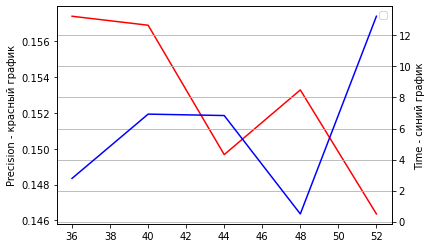

In [37]:
x = [36, 40, 44, 48, 52]
y1 = result_t
y2 = time_t
plt.figure(figsize=(12, 7))

fig, ax = plt.subplots()

ax1 = ax.twinx()
ax.plot(x,y1,color='r')
ax1.plot(x,y2,color='b')

ax.set_ylabel('Precision - красный график')
ax1.set_ylabel('Time - синий график')

#plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
#plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [38]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [39]:
%%time

model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=100, 
                                calculate_training_loss=True, 
                                use_gpu=False) 

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: total: 1min 4s
Wall time: 9.39 s


In [40]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.10326469110999499

In [44]:
# теперь переберем гиперпараметр factors из пяти вариантов для bm25-взвешивания

In [42]:
    result_t2 = []
    
    time_t2 = []
    
    
    for factor in [36, 40, 44, 48, 52]:
    #for iteration in [10, 15, 20, 25, 30]:
    
        model = AlternatingLeastSquares(factors=factor, 
                                regularization=0.001,
                                iterations=100, 
                                calculate_training_loss=True, 
                                use_gpu=False)
    
        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
    
        result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        #print(%%time)
        
        start_time = datetime.now()
        
        time.sleep(5)
        
        time_ = (datetime.now() - start_time).microseconds/1000
        
        time_t2.append(time_)
        
        result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
        
        result_t2.append(result_)
        
        #print(time_t2)
    
        #print(result_t2)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
# отобразим на графике закономерность между наращиванием количества факторов factors и временем обработки кода,
# а также между наращиванием аращиванием количества факторов factors и метрикой precision_at_k

<Figure size 864x504 with 0 Axes>

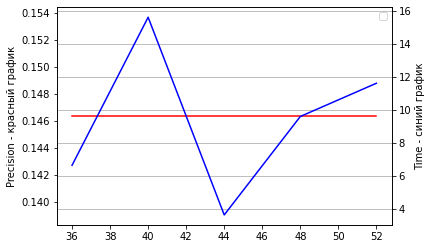

In [46]:
x = [36, 40, 44, 48, 52]
y1 = result_t2
y2 = time_t2
plt.figure(figsize=(12, 7))

fig, ax = plt.subplots()

ax1 = ax.twinx()
ax.plot(x,y1,color='r')
ax1.plot(x,y2,color='b')

ax.set_ylabel('Precision - красный график')
ax1.set_ylabel('Time - синий график')

#plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
#plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [47]:
# на графике выше видно, что precision осталась устойчивой к изменению количества факторов factors 
# при cхожей с tfidf временной динамике выполнения кода

In [49]:
# поскольку tfidf-взвешивание ориентировано на частоту встречающихся объектов, добавление латентных факторов может улучшать 
# результат модели, однако вероятнее всего ведет к ее переобучению и получению необъективной информации о том, 
# что можно порекомендовать покупателю

In [50]:
# bm25-взвешивание ориентировано не только на частоту встречающихся объектов, но и на их тематическую плотность,
# что, видимо, при добавлении латентных факторов не меняет качество модели, что в свою очередь 
# позволяет получить более объективный подход к рекомендации товара 

In [40]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def tune_ALS(train_data, test_data, maxIter, regParams, ranks):
    
     # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    
    

In [55]:
tfidf_params = {
    'factors': range (36, 52, 4),
    #'regularization': range (0.001, 0.005, 0.001),
    'iterations': range (5, 25, 5)
}

In [56]:
clf = GridSearchCV(model, tfidf_params)
clf.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <implicit.cpu.als.AlternatingLeastSquares object at 0x000001C3B4F0B760> does not.

In [54]:
clf.best_params

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [79]:
#tfidf tuning
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn import metrics

tfidf_params = {
    'factors': hp.choice('factors', [30, 40, 44, 50, 55]),
    'regularization': hp.choice('regularization', [0.001, 0.002, 0.003, 0.004, 0.005]),
    'iterations': hp.choice('iterations', [10, 15, 20, 25, 30])
}

In [80]:
def tfidf_try(tfidf_params):
    model = AlternatingLeastSquares(factors=tfidf_params['factors'], 
                                regularization=tfidf_params['regularization'],
                                iterations=tfidf_params['iterations'], 
                                calculate_training_loss=True, 
                                use_gpu=False)
    
    accuracy = precision_at_k(model, data_train, data_test).mean()
    
    #result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
    
    return {'loss': accuracy, 'status':STATUS_OK}

In [81]:
trials=Trials()
best = fmin(fn = tfidf_try,
           space = tfidf_params,
            algo = tpe.suggest,
            max_evals=10,
            trials=trials)
best

  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [46]:
#pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ------------------------------------- 199.7/199.7 KB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 10.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
